***

# Dimensionality Reduction

## Feature Extaction

### - PCA
        - Scikit-Learn Dcoumentation - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
        - PCA in Python - https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
        - PCA Data Visualizsation - https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_Data_Visualization_Iris_Dataset_Blog.ipynb
        - PCA in ML Algorithms - https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_to_Speed-up_Machine_Learning_Algorithms.ipynb

## Feature Selection

### - Elastic Net
        - USED - https://www.kaggle.com/den3b81/elasticnet-lb-0-547-and-feature-importance
        - https://www.kaggle.com/cast42/feature-selection-and-elastic-net
        
### - LASSO
        - https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b
        



***

In [272]:
### Import Packages 
import pandas as pd
import datetime
import gc
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import cross_val_score
from itertools import product
from sklearn.metrics import r2_score
import warnings
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression


#Plotting
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()



#### Read in Data

In [200]:
# read in our data
url = "https://raw.githubusercontent.com/SamIlic/Stat479_Project/master/Data/prices.csv"
df_ORIGINAL = pd.read_csv(url)


#### Clean Data & Create Features

In [234]:
df_features = df_ORIGINAL
df_features['date'] = pd.to_datetime(df_features['date'])
df_features.head()

date Ticker       open      close        low       high     volume
0 2010-01-04    AAL   4.840000   4.770000   4.660000   4.940000    9837300
1 2010-01-04    AAP  40.700001  40.380001  40.360001  41.040001    1701700
2 2010-01-04   AAPL  30.490000  30.572857  30.340000  30.642857  123432400
3 2010-01-04    ABC  26.290001  26.629999  26.139999  26.690001    2455900
4 2010-01-04    ABT  26.000339  26.129884  25.870792  26.177866   10829000

In [235]:
"""
### Create Lag Features
this is exactly what the book does for create_lag_features from chapter 29
"""
def create_lag_features(df, lag_days):
    df_ret = df.copy()
    
    # iterate through the lag days to generate lag values up to lag_days + 1
    for i in range(1,lag_days + 2):
        df_lag = df_ret[['date', 'Ticker', 'close']].copy()
        # generate dataframe to shift index by i day. 415 is number of stocks
        df_lag['date'] = df_lag['date'].shift(-i*415)
        df_lag.columns = ['date', 'Ticker', 'value_lag' + str(i)]
        # combine the valuelag
        df_ret = pd.merge(df_ret, df_lag, how = 'left', left_on = ['date', 'Ticker'], right_on = ['date', 'Ticker'])
    
    #frees memory
    del df_lag
    
    # calculate today's percentage lag
    df_ret['Today'] = (df_ret['close'] - df_ret['value_lag1'])/(df_ret['value_lag1']) * 100.0 
    
    # calculate percentage lag
    for i in range(1, lag_days + 1):
        df_ret['lag' + str(i)] = (df_ret['value_lag'+ str(i)] - df_ret['value_lag'+ str(i+1)])/(df_ret['value_lag'+str(i+1)]) * 100.0
    
    # drop unneeded columns which are value_lags
    for i in range(1, lag_days + 2):
        df_ret.drop(['value_lag' + str(i)], axis = 1, inplace = True)
                                                                                                                                                                                                                                                                                                                                     
    return df_ret

In [236]:
df_features = create_lag_features(df_features, 5) # 5 lag features

# drop earlier data with missing lag features
df_features.dropna(inplace=True)

# finds all unique stocks
uniq_stocks = set(df_features['Ticker'])


# loop through stock data here for additional features [MAY BE PICK ONLY 100/400 stocks???]
# Final model we should use say 100
# when training, for the purpose of time, we should use <=10
Ticker = "AAPL"
X_one = df_features.loc[df_features['Ticker'] == Ticker, :]

a = ['Date', 'Ticker', 'Open', 'Close', 'Low', 'High', 'Volume', 'Today']
for i in range(1,6):
    a.append('lag' + str(i))
X_one.columns = a
X_one = X_one.reset_index(drop = True)


# Technical Indicators
from technical_indicators import * # import all function

X_one = standard_deviation(X_one, 14)

X_one = relative_strength_index(X_one, 14) # periods
X_one = average_directional_movement_index(X_one, 14, 13) # n, n_ADX
X_one = moving_average(X_one, 21) # periods
X_one = exponential_moving_average(X_one, 21) # periods
X_one = momentum(X_one, 14) # 

X_one = average_true_range(X_one, 14)
X_one = bollinger_bands(X_one, 21)
X_one = ppsr(X_one)
X_one = stochastic_oscillator_k(X_one)
X_one = stochastic_oscillator_d(X_one, 14)
X_one = trix(X_one, 14)
X_one = macd(X_one, 26, 12)
X_one = mass_index(X_one)
X_one = vortex_indicator(X_one, 14)

X_one = kst_oscillator(X_one, 10, 10, 10, 15, 10, 15, 20, 30)
X_one = true_strength_index(X_one, 25, 13)

#X_one = accumulation_distribution(X_one, 14) # Causes Problems, apparently
X_one = chaikin_oscillator(X_one)
X_one = money_flow_index(X_one, 14)
X_one = on_balance_volume(X_one, 14)
X_one = force_index(X_one, 14)
X_one = ease_of_movement(X_one, 14)
X_one = commodity_channel_index(X_one, 14)
X_one = keltner_channel(X_one, 14)
X_one = ultimate_oscillator(X_one)
X_one = donchian_channel(X_one, 14)

# drop earlier data with missing lag features
X_one.dropna(inplace=True)
X_one = X_one.reset_index(drop = True)

# Sanity Check
X_one = X_one.set_index('Date')
X_one = X_one.drop(['Ticker', 'Open', 'Close', 'Low', 'High'], axis = 1)
X_one.head(5)


Volume     Today      lag1      lag2      lag3      lag4  \
Date                                                                      
2010-03-16  111727000  0.272517 -1.218010  0.487804  0.293549  0.816065   
2010-03-17  112739200 -0.147023  0.272517 -1.218010  0.487804  0.293549   
2010-03-18   85527400  0.236480 -0.147023  0.272517 -1.218010  0.487804   
2010-03-19  139861400 -1.068329  0.236480 -0.147023  0.272517 -1.218010   
2010-03-22  114104900  1.124861 -1.068329  0.236480 -0.147023  0.272517   

                lag5    STD_14    RSI_14  ADX_14_13     ...         MFI_14  \
Date                                                    ...                  
2010-03-16  1.798434  1.237845  0.647188   0.495303     ...       0.857143   
2010-03-17  0.816065  1.113362  0.680559   0.466846     ...       0.857143   
2010-03-18  0.293549  0.989406  0.648769   0.423618     ...       0.785714   
2010-03-19  0.487804  0.893243  0.583060   0.372603     ...       0.714286   
2010-03-22 -1.218010  0.766624  0.534203   0.355591     ...       0.714286   

                OBV_14      Force_14        EoM_14    CCI_14  KelChM_14  \
Date                                                                      
2010-03-16  98493650.0 -1.160476e+07  7.072544e-10  0.917130  30.844762   
2010-03-17  78563600.0 -1.691937e+08  7.408014e-10  0.887389  31.089966   
2010-03-18  75610900.0 -1.182852e+08  5.626915e-10  0.720634  31.295646   
2010-03-19  55797700.0  4.428839e+06  3.718736e-10  0.444165  31.447959   
2010-03-22  74064950.0 -6.253631e+07  3.023533e-10  0.454084  31.595850   

            KelChU_14  KelChD_14  Ultimate_Osc  Donchian_14  
Date                                                         
2010-03-16  31.341497  30.348027      4.838738     1.922857  
2010-03-17  31.558231  30.621701      4.649647     1.595715  
2010-03-18  31.755952  30.835340      4.628263     2.205715  
2010-03-19  31.907857  30.988061      4.214674     2.395716  
2010-03-22  32.083911  31.107789      4.341849     2.395716  

[5 rows x 44 columns]

***

## PCA

#### Standardize Data

In [237]:
from sklearn import preprocessing

# Surpress warnings
warnings.filterwarnings(action='once')


X_one_standardized = X_one
dates = X_one_standardized.index # get dates to set as index after data is standardized
names = X_one_standardized.columns # Get column names first

# Standardize
X_one_standardized = StandardScaler().fit_transform(X_one_standardized)

# Convert to DataFrame
X_one_standardized = pd.DataFrame(X_one_standardized, columns=names, index=dates)

X_one_standardized.head(7)

/Users/YoungFreeesh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/YoungFreeesh/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Volume     Today      lag1      lag2      lag3      lag4  \
Date                                                                     
2010-03-16  0.332509  0.111379 -0.793763  0.242255  0.124362  0.441576   
2010-03-17  0.349827 -0.143552  0.111782 -0.794096  0.242383  0.124135   
2010-03-18 -0.115747  0.089482 -0.143102  0.111459 -0.793997  0.242150   
2010-03-19  0.813869 -0.703378  0.089889 -0.143428  0.111583 -0.794172   
2010-03-22  0.373193  0.629302 -0.702827  0.089565 -0.143311  0.111358   
2010-03-23  0.997732  0.921800  0.629610 -0.703159  0.089689 -0.143523   
2010-03-24  0.977839  0.214540  0.922055  0.629293 -0.703058  0.089465   

                lag5    STD_14    RSI_14  ADX_14_13     ...         MFI_14  \
Date                                                    ...                  
2010-03-16  1.037253 -0.632319  0.614867   1.056946     ...       1.917014   
2010-03-17  0.440593 -0.756851  0.775175   0.846887     ...       1.917014   
2010-03-18  0.123232 -0.880857  0.622461   0.527800     ...       1.479831   
2010-03-19  0.241217 -0.977060  0.306812   0.151233     ...       1.042649   
2010-03-22 -0.794842 -1.103729  0.072110   0.025654     ...       1.042649   
2010-03-23  0.110458 -1.250881  0.518023   0.001167     ...       1.479831   
2010-03-24 -0.144358 -1.452115  0.706341  -0.156765     ...       1.479831   

              OBV_14  Force_14    EoM_14    CCI_14  KelChM_14  KelChU_14  \
Date                                                                       
2010-03-16  3.107310  0.030016  0.094272  0.550675  -1.810075  -1.816879   
2010-03-17  2.473749 -0.532518  0.097015  0.527400  -1.801133  -1.809106   
2010-03-18  2.379885 -0.350794  0.082454  0.396898  -1.793632  -1.802014   
2010-03-19  1.750038  0.087250  0.066855  0.180535  -1.788077  -1.796566   
2010-03-22  2.330740 -0.151791  0.061172  0.188297  -1.782684  -1.790252   
2010-03-23  2.461518  0.630354  0.074572  0.662628  -1.775973  -1.782646   
2010-03-24  2.593068  0.622725  0.077158  1.227027  -1.768924  -1.775568   

            KelChD_14  Ultimate_Osc  Donchian_14  
Date                                              
2010-03-16  -1.802524      1.536356    -1.490424  
2010-03-17  -1.792375      1.283215    -1.579143  
2010-03-18  -1.784453      1.254588    -1.413714  
2010-03-19  -1.778789      0.700901    -1.362187  
2010-03-22  -1.774350      0.871154    -1.362187  
2010-03-23  -1.768566      1.264944    -1.414490  
2010-03-24  -1.761551      1.356698    -1.082470  

[7 rows x 44 columns]

Text(0.5, 1.0, 'Scree Plot -- X_one_standardized')

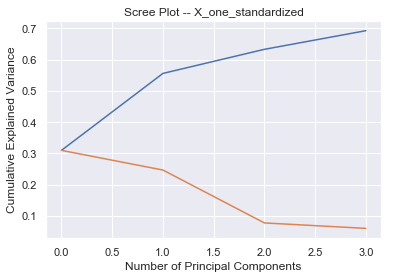

In [238]:
### 100%
pca_all = PCA().fit(X_one_standardized)
# plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
# plt.plot((pca_all.explained_variance_ratio_))
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Explained Variance');
# plt.title('PCA')

### 95%
pca95 = PCA(.95).fit(X_one_standardized)
# plt.plot(np.cumsum(pca95.explained_variance_ratio_))
# plt.plot((pca95.explained_variance_ratio_))
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Explained Variance');
# plt.title('PCA')

### 90%
pca90 = PCA(.90).fit(X_one_standardized)
# plt.plot(np.cumsum(pca90.explained_variance_ratio_))
# plt.plot((pca90.explained_variance_ratio_))
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Explained Variance');
# plt.title('PCA')

### 80% - 8 components
pca80 = PCA(.80).fit(X_one_standardized)
# plt.plot(np.cumsum(pca80.explained_variance_ratio_))
# plt.plot((pca80.explained_variance_ratio_))
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Explained Variance');
# plt.title('Scree Plot -- X_one_standardized')

### 65% - 3 components
pca65 = PCA(.65).fit(X_one_standardized)
plt.plot(np.cumsum(pca65.explained_variance_ratio_))
plt.plot((pca65.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance');
plt.title('Scree Plot -- X_one_standardized')


### Transform Data

In [239]:
def create_column_names(numColumns):
    colNames = []
    for i in range(numColumns):
        tempName = "PC" + str(i+1)
        colNames.append(tempName)
        
    return colNames

# pca_all
X_one_standardized_pca_all_transformed = pca_all.transform(X_one_standardized)
X_one_standardized_pca_all_transformed = pd.DataFrame(X_one_standardized_pca_all_transformed, columns=create_column_names(X_one_standardized_pca_all_transformed.shape[1]), index=dates)

# pca95
X_one_standardized_pca95_transformed = pca95.transform(X_one_standardized)
X_one_standardized_pca95_transformed = pd.DataFrame(X_one_standardized_pca95_transformed, columns=create_column_names(X_one_standardized_pca95_transformed.shape[1]), index=dates)

# pca90
X_one_standardized_pca90_transformed = pca90.transform(X_one_standardized)
X_one_standardized_pca90_transformed = pd.DataFrame(X_one_standardized_pca90_transformed, columns=create_column_names(X_one_standardized_pca90_transformed.shape[1]), index=dates)

# pca80
X_one_standardized_pca80_transformed = pca80.transform(X_one_standardized)
X_one_standardized_pca80_transformed = pd.DataFrame(X_one_standardized_pca80_transformed, columns=create_column_names(X_one_standardized_pca80_transformed.shape[1]), index=dates)

# pca65
X_one_standardized_pca65_transformed = pca65.transform(X_one_standardized)
X_one_standardized_pca65_transformed = pd.DataFrame(X_one_standardized_pca65_transformed, columns=create_column_names(X_one_standardized_pca65_transformed.shape[1]), index=dates)

X_one_standardized_pca80_transformed.head(10)

PC1       PC2       PC3       PC4       PC5       PC6  \
Date                                                                     
2010-03-16  7.675420  2.555207 -0.095994  0.840478  0.277286  1.802932   
2010-03-17  7.536179  1.999875  1.112609  0.404133  1.626887  1.177609   
2010-03-18  7.425849  1.859706  0.199409  0.474719 -0.207920  1.294305   
2010-03-19  7.245156  0.665392  1.750397  0.068002  1.358084  0.122577   
2010-03-22  7.250307  0.967475  0.429071  0.307021 -0.831973  1.130622   
2010-03-23  7.611763  1.919025 -0.503375  0.627558 -1.602398  0.472507   
2010-03-24  7.633915  2.173293 -0.268915  0.246105 -0.809333 -0.389886   
2010-03-25  7.171143  0.761419  1.843922 -0.545836  1.611312 -0.554006   
2010-03-26  7.373515  1.465664  0.204921  0.016379 -0.759542  0.573285   
2010-03-29  7.238960  1.425596  0.878068 -0.334700  0.616540  0.285131   

                 PC7       PC8  
Date                            
2010-03-16 -1.728340  1.065288  
2010-03-17 -2.046289  0.511907  
2010-03-18 -1.920679  0.869045  
2010-03-19 -1.496999  0.500003  
2010-03-22 -1.116137  1.576225  
2010-03-23 -1.455944  0.027399  
2010-03-24 -1.023607  0.129770  
2010-03-25 -0.203041  0.537613  
2010-03-26  0.536858  1.283002  
2010-03-29 -0.444314 -0.907492

***

## Elastic Net

#### Create Training-Test Split

In [240]:
# Todays returns
y_one = X_one_standardized['Today'] 

In [246]:
# Remove Today
X_one_standardized = X_one_standardized.loc[:, X_one_standardized.columns != 'Today']

# Can't use tomorrows data to predict tomorrows prices!!!
X_train_one = X_one_standardized.loc[(X_one_standardized.index < '2016-01-01'),:]
y_train_one = y_one[X_train_one.index]

X_test_one = X_one_standardized.loc[(X_one_standardized.index > '2016-01-01'),:]
y_test_one = y_one[X_test_one.index]

# X_train_one.drop(['Date', 'Ticker'], axis = 1, inplace = True)
# X_test_one.drop(['Date', 'Ticker'], axis = 1, inplace = True)


X_train_one.head(5)

Volume      lag1      lag2      lag3      lag4      lag5  \
Date                                                                     
2010-03-16  0.332509 -0.793763  0.242255  0.124362  0.441576  1.037253   
2010-03-17  0.349827  0.111782 -0.794096  0.242383  0.124135  0.440593   
2010-03-18 -0.115747 -0.143102  0.111459 -0.793997  0.242150  0.123232   
2010-03-19  0.813869  0.089889 -0.143428  0.111583 -0.794172  0.241217   
2010-03-22  0.373193 -0.702827  0.089565 -0.143311  0.111358 -0.794842   

              STD_14    RSI_14  ADX_14_13     MA_21     ...         MFI_14  \
Date                                                    ...                  
2010-03-16 -0.632319  0.614867   1.056946 -1.826737     ...       1.917014   
2010-03-17 -0.756851  0.775175   0.846887 -1.821599     ...       1.917014   
2010-03-18 -0.880857  0.622461   0.527800 -1.816118     ...       1.479831   
2010-03-19 -0.977060  0.306812   0.151233 -1.811327     ...       1.042649   
2010-03-22 -1.103729  0.072110   0.025654 -1.805604     ...       1.042649   

              OBV_14  Force_14    EoM_14    CCI_14  KelChM_14  KelChU_14  \
Date                                                                       
2010-03-16  3.107310  0.030016  0.094272  0.550675  -1.810075  -1.816879   
2010-03-17  2.473749 -0.532518  0.097015  0.527400  -1.801133  -1.809106   
2010-03-18  2.379885 -0.350794  0.082454  0.396898  -1.793632  -1.802014   
2010-03-19  1.750038  0.087250  0.066855  0.180535  -1.788077  -1.796566   
2010-03-22  2.330740 -0.151791  0.061172  0.188297  -1.782684  -1.790252   

            KelChD_14  Ultimate_Osc  Donchian_14  
Date                                              
2010-03-16  -1.802524      1.536356    -1.490424  
2010-03-17  -1.792375      1.283215    -1.579143  
2010-03-18  -1.784453      1.254588    -1.413714  
2010-03-19  -1.778789      0.700901    -1.362187  
2010-03-22  -1.774350      0.871154    -1.362187  

[5 rows x 43 columns]

In [254]:
# Surpress Warnings
warnings.filterwarnings('ignore')


# Let's perform a cross-validation to find the best combination of alpha and l1_ratio
from sklearn.linear_model import ElasticNetCV, ElasticNet

cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=None, selection='cyclic')

cv_model.fit(X_train_one, y_train_one)


ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 0.995, 1], max_iter=2000,
       n_alphas=100, n_jobs=-1, normalize=True, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

In [255]:
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)
#L1 Ratio of 1 --> we are just using LASSO

Optimal alpha: 0.00001776
Optimal l1_ratio: 1.000
Number of iterations 2000


In [256]:
# train model with best parameters from CV
model = ElasticNet(l1_ratio=cv_model.l1_ratio_, alpha = cv_model.alpha_, max_iter=cv_model.n_iter_, fit_intercept=True, normalize = True)
model.fit(X_train_one, y_train_one)

ElasticNet(alpha=1.7761744550929223e-05, copy_X=True, fit_intercept=True,
      l1_ratio=1.0, max_iter=2000, normalize=True, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)

In [257]:
# r2 score on training dataset
print(r2_score(y_train_one, model.predict(X_train_one)))

0.849081200931323


#### Feature Importance

Importance of each feature based on the absolute value of coefficients

It's nice to see how these features compares with those selected by xgboost or other nonlinear methods. Anyway, 13.95% features reduction (with respect to dataset with dummies) looks nice. Besides, the performance on the LB of this linear method seems to be close to those of more sophisticated ones.


37 features, reduction of 13.95%


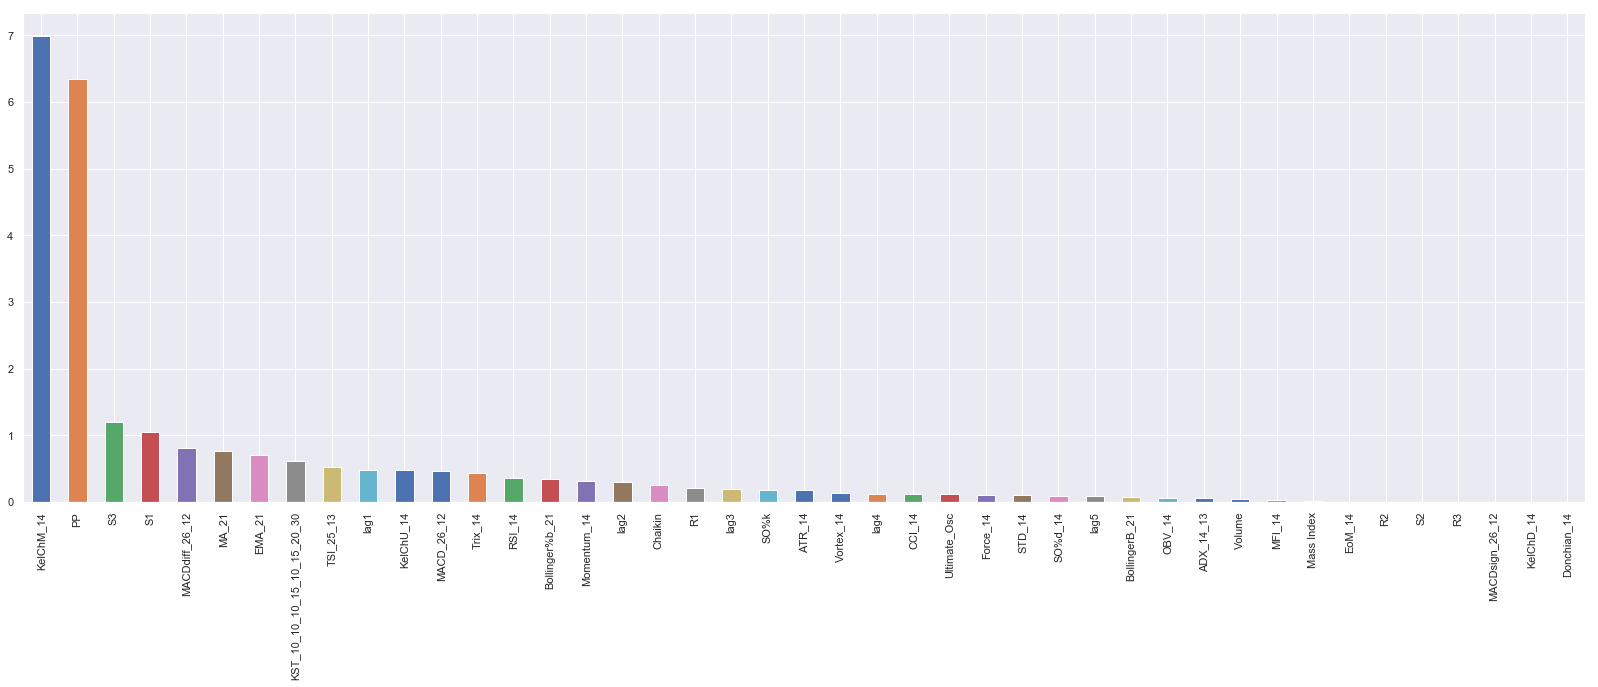

In [271]:
feature_importance = pd.Series(index = X_train_one.columns, data = np.abs(model.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values(ascending=False).tail(50).plot(kind = 'bar', figsize = (28,9))

## LASSO

In [290]:

X_train = X_train_one
y_train = y_train_one

X_test = X_test_one
y_test = y_test_one

lasso = Lasso()
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print("training score:", train_score )
print("test score: ", test_score)
print("number of features used: ", coeff_used)
lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X_train,y_train)
train_score001=lasso001.score(X_train,y_train)
test_score001=lasso001.score(X_test,y_test)
coeff_used001 = np.sum(lasso001.coef_!=0)
print("training score for alpha=0.01:", train_score001)
print("test score for alpha =0.01: ", test_score001)
print("number of features used: for alpha =0.01:", coeff_used001)
lasso00001 = Lasso(alpha=0.0001, max_iter=10e5)
lasso00001.fit(X_train,y_train)
train_score00001=lasso00001.score(X_train,y_train)
test_score00001=lasso00001.score(X_test,y_test)
coeff_used00001 = np.sum(lasso00001.coef_!=0)
print("training score for alpha=0.0001:", train_score00001)
print("test score for alpha =0.0001: ", test_score00001)
print("number of features used: for alpha =0.0001:", coeff_used00001)
lr = LinearRegression()
lr.fit(X_train,y_train)
lr_train_score=lr.score(X_train,y_train)
lr_test_score=lr.score(X_test,y_test)
print("LR training score:", lr_train_score)
print("LR test score: ", lr_test_score)



training score: 0.0
test score:  -0.0008759886298115305
number of features used:  0
training score for alpha=0.01: 0.7480382262320432
test score for alpha =0.01:  0.6662791894275607
number of features used: for alpha =0.01: 24
training score for alpha=0.0001: 0.9087162142774026
test score for alpha =0.0001:  0.9111936220007029
number of features used: for alpha =0.0001: 38
LR training score: 0.9030597623402689
LR test score:  0.8761847716880822


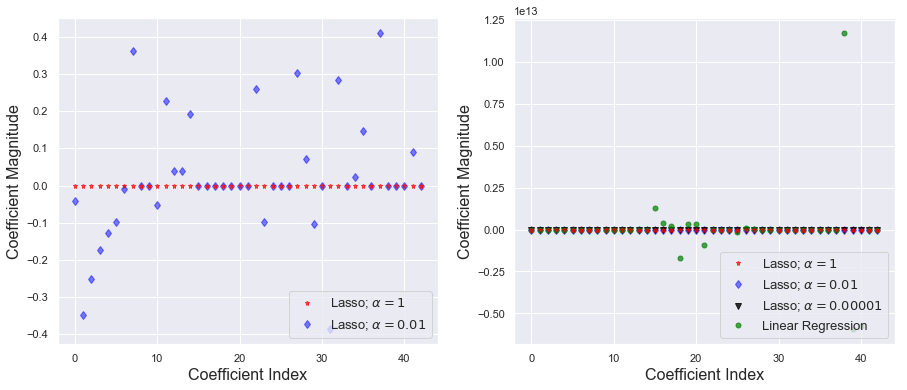

In [289]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 6))

plt.subplot(1,2,1)
plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency

plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.subplot(1,2,2)
plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency
plt.plot(lasso00001.coef_,alpha=0.8,linestyle='none',marker='v',markersize=6,color='black',label=r'Lasso; $\alpha = 0.00001$') # alpha here is for transparency
plt.plot(lr.coef_,alpha=0.7,linestyle='none',marker='o',markersize=5,color='green',label='Linear Regression',zorder=2)
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
#plt.tight_layout()
plt.show()